In [174]:
import praw
import prawcore
import pandas as pd
import numpy as np 
import os
import re
import math
from scipy import stats

from tqdm import tqdm
from datetime import datetime, date

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, precision_recall_curve
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt

import statsmodels.api as sm

pd.options.mode.chained_assignment = None  # default='warn'


# from spacy import load
# import warnings
# warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

In [2]:
path = 'data/user_data'

In [102]:
def data_parser(infile_name, index_col = 0):

    path = 'data/user_data'

    df = pd.read_csv(f'{path}/{infile_name}', index_col = index_col)
    bot_substrings = ['bot', 'b0t']
    
    heuristics = []

    for ind in df.index:
        Flag = False
        if any(x in df['username'][ind] for x in bot_substrings):
            Flag = True
        elif pd.to_timedelta(df['avg_reply_speed'][ind]) < pd.to_timedelta('0 days 00:05:00'):
            Flag = True
        elif pd.to_timedelta(df['avg_comment_time_interval'][ind]) < pd.to_timedelta('0 days 00:05:00'):
            Flag = True
        elif df['avg_comment_similarity'][ind] >= .8 or df['avg_comment_similarity'][ind] <= .1:
            Flag = True
        elif df['karma_ratio'][ind] < .15:
            Flag = True
        else:
            Flag = False
        if Flag:
            heuristics.append(1)
        else:
            heuristics.append(0)
    df['heuristic'] = heuristics
    
    for ind in df.index:
        df['avg_comment_time_interval'][ind] = float(pd.to_timedelta(df['avg_comment_time_interval'][ind]).total_seconds())
        df['avg_reply_speed'][ind] = float(pd.to_timedelta(df['avg_reply_speed'][ind]).total_seconds())
    
    df['username'] = df['username'].str.lower()
    cols = ['comment_karma', 'submission_karma', 'karma_ratio', 'avg_reply_speed', 'avg_comment_time_interval']
    df[cols] = df[cols].astype(float)
    
    df = df[(np.abs(stats.zscore(df[cols])) < 3).all(axis=1)]

    return df

In [91]:
df_sus = data_parser('raw_suspected_bots.csv')
df_sus = df_sus.sample(n = 500, replace=True, random_state=1, ignore_index = True)
df_sus['label'] = 1

In [111]:
df_sus

,username,comment_karma,submission_karma,karma_ratio,avg_comment_similarity,avg_toxicity,avg_reply_speed,avg_comment_time_interval,heuristic,label
0,cuspiafc,2.0,1.0,2.0000,0.157662,0.000949,47959.0,16.0,1,1
1,lompje,2.0,1.0,2.0000,0.614178,0.007433,2160.0,22425.0,0,1
2,outrightfoal480,3.0,1.0,3.0000,0.000000,0.061515,4324.0,1939.0,1,1
3,potential_ad9781,25.0,29.0,0.8621,0.377999,0.000973,1309.0,29448.0,0,1
4,aromatic-noise-1345,3.0,1.0,3.0000,0.684705,0.008319,150.0,1787.0,1,1
...,...,...,...,...,...,...,...,...,...,...
495,theusablesuccess,341.0,1258.0,0.2711,0.000000,0.013383,2318.0,17997.0,1,1
496,presentequivalent459,36.0,1.0,36.0000,0.496566,0.017939,3182.0,26.0,1,1
497,photochiguireao,100.0,249.0,0.4016,0.556088,0.016173,159454.0,1061.0,0,1
498,evilpotato45,574.0,1.0,574.0000,0.615056,0.229536,280.0,36.0,1,1


In [92]:
df_all = data_parser('raw_known_bots.csv')
df_all.sample(n = 500, replace=True, random_state=1, ignore_index = True)
df_all['label'] = 1

In [103]:
df_cons = data_parser('raw_users_conservative.csv', index_col = False)
df_cons = df_cons.sample(n = 1500, replace=True, random_state=1, ignore_index = True)
df_cons['label'] = 0

In [104]:
df_pol = data_parser('raw_users_politics.csv', index_col = False)
df_pol = df_pol.sample(n = 1500, replace=True, random_state=1, ignore_index = True)
df_pol['label'] = 0

In [157]:
df_sus_model = pd.concat([df_sus, df_cons])
df_known_model = pd.concat([df_all, df_cons])

In [158]:
def feature_extraction(df):
    df_copy = df.copy()
#     df_copy.drop(columns=['avg_toxicity'])

    
    usernames = df_copy.values[:, 1]
    comment_karma = df_copy.values[:, 2]
    submission_karma = df_copy.values[:, 3]
    karma_ratio = df_copy.values[:, 4]
    comment_similarity = df_copy.values[:, 5]
    toxicity = df_copy.values[:, 6]
    reply_speed = df_copy.values[:, 7]
    time_interval = df_copy.values[:, 8]
    heuristics = df_copy.values[:, 9]

    features = df_copy.values[:, 1:9]
    labels = df_copy.values[:, 9]
    
    return features, labels

In [159]:
def train_df(df):
    features, labels = feature_extraction(df)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=104, test_size=.2, shuffle=True)
    
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    

    clf = LogisticRegression()

    clf.fit(X_train, y_train)
    print('Coefficients: \n', clf.coef_)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    return y_pred, y_test, y_score
 

In [171]:
def train_for_logit_df(df, df_type = 'sus'):
    features, labels = feature_extraction(df)
    

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=104, test_size=.2, shuffle=True)
    
    X_test = X_test.astype(np.float64)
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    column_name = ["comment_karma", "submission_karma", "karma_ratio", "avg_comment_similarity", "avg_toxicity", "avg_reply_speed","avg_comment_time_interval", "heuristic"]
    

    logit_model=sm.Logit(y_train, X_train)
    result=logit_model.fit()
    
    
    
    print(result.summary(xname=column_name))
    
    probabilities  = result.predict(X_test)
    y_pred = (probabilities >= 0.5).astype(int)
    
    with open(f'summary_{df_type}.txt', 'w') as fh:
        fh.write(result.summary(xname=column_name).as_text())
    
    return y_pred, y_test, probabilities, result
 

In [161]:
def matrix(y_test, y_pred, cmap='Blues', fig_type = 'sus'):
    matrix = confusion_matrix(y_test, y_pred)


    classes = ['Not Bot', 'Bot']

    plt.matshow(matrix, cmap=cmap)
    if fig_type == 'sus':
        plt.title('Suspected Bot Predictions')
    else:
        plt.title('Known Bot Predictions')
#     plt.colorbar()
    plt.clim(0, 450)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')

    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, matrix[i, j], ha='center', va='center')
    
    plt.savefig(f"confusion_matrix_{fig_type}.png", dpi=800, bbox_inches = "tight")

In [172]:
y_pred_sus, y_test_sus, y_score_sus, sus_model = train_for_logit_df(df_sus_model)

Optimization terminated successfully.
         Current function value: 0.100252
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1592
Method:                           MLE   Df Model:                            7
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.8222
Time:                        23:30:22   Log-Likelihood:                -160.40
converged:                       True   LL-Null:                       -901.93
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
comment_karma                -0.0028      0.000     -7.030      0.000      -0

In [173]:
y_pred_all, y_test_all, y_score_all, known_model = train_for_logit_df(df_known_model, df_type = 'known')

Optimization terminated successfully.
         Current function value: 0.325727
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2090
Model:                          Logit   Df Residuals:                     2082
Method:                           MLE   Df Model:                            7
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.5228
Time:                        23:30:28   Log-Likelihood:                -680.77
converged:                       True   LL-Null:                       -1426.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
comment_karma             -1.139e-06   1.68e-06     -0.679      0.497   -4.43e

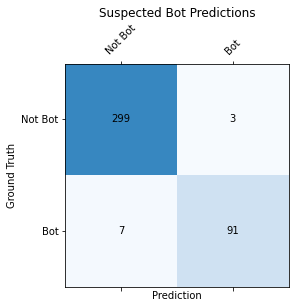

In [164]:
matrix(y_test_sus, y_pred_sus)

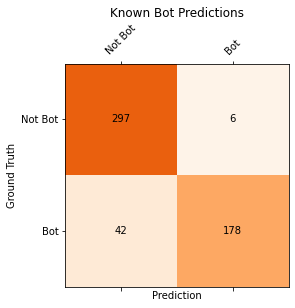

In [165]:
matrix(y_test_all, y_pred_all, cmap="Oranges", fig_type = 'known')

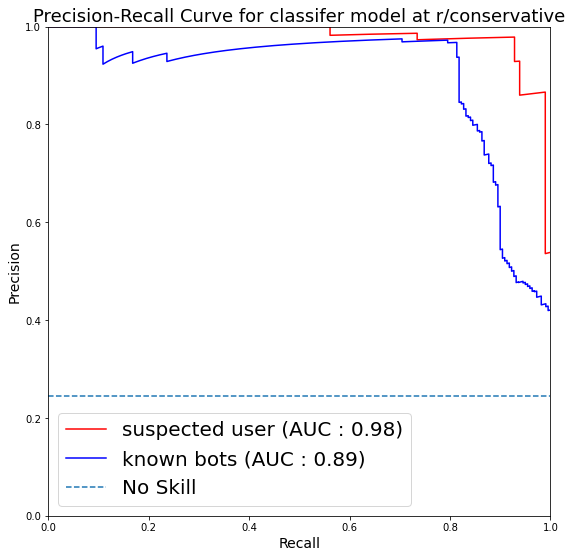

In [170]:
precision_sus, recall_sus, thresholds_sus = precision_recall_curve(y_test_sus, y_score_sus)
precision_all, recall_all, thresholds_all = precision_recall_curve(y_test_all, y_score_all)

plt.figure(figsize=(9, 9))
plt.plot(recall_sus, precision_sus, 'r', label='suspected user (AUC : 0.98)')
plt.plot(recall_all, precision_all, 'b', label='known bots (AUC : 0.89)')
no_skill = len(y_test_sus[y_test_sus==1]) / len(y_test_sus)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
leg = plt.legend(prop={'size': 20})
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Precision-Recall Curve for classifer model at r/conservative", fontsize=18)

plt.savefig(f"pr_curve.png", dpi=1200)

plt.show()


In [167]:
auc(recall_sus, precision_sus)

0.9801921651591485

In [168]:
auc(recall_all, precision_all)

0.8972806770719856

In [13]:
pairs = {'recall_sus': recall_sus, 'precision_sus': precision_sus}

precision_sus_df = pd.DataFrame.from_dict(pairs)

precision_sus_df.to_csv('precision_sus_df.csv', index = False)